In [281]:
import numpy as np
import pandas as pd 

import datetime

%matplotlib inline 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import metrics

# 0. Idée de manoeuvre pré-majoration

Y a eu un kaggle sur le sujet, on va donc s'en inspirer. (ce n'est pas le même dataset)
Voici le lien du kaggle: https://www.kaggle.com/c/home-credit-default-risk/overview

Voici un notebook introductif: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

Voici un notebook avec un bon score: https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

J'ai bien envie de combiner un neural network et un XGBoost, en général c'est bénèf. 

# 1. Exploration and transformation of the data

## 1.1. A first glance at the data 

In [282]:
data = pd.read_csv('data/CreditTraining.csv', parse_dates=[3, 4, 13, 17])
data.head(5)

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,7440,0,Non Existing Client,1977-07-08,2012-02-13,NP_Client,University,Married,3.0,1,36,1.0,C,2012-02-14,Sales,Owned,1,NaT,B
1,573,0,Existing Client,1974-06-13,2009-04-02,P_Client,University,Married,0.0,12,18,2.0,C,2011-06-30,Sales,Parents,1,NaT,G
2,9194,0,Non Existing Client,1973-07-11,2012-03-04,NP_Client,University,Married,2.0,10,36,1.0,C,2012-04-04,Sales,Owned,1,NaT,B
3,3016,1,Existing Client,1982-08-07,2011-08-25,NP_Client,University,Married,3.0,3,36,1.0,C,2011-07-09,Sales,New rent,1,2012-12-31,L
4,6524,0,Non Existing Client,1953-08-18,2012-10-01,NP_Client,University,Married,2.0,1,36,1.0,C,2012-11-01,Sales,Owned,1,NaT,D


In [283]:
# data.dtypes

In [284]:
data.shape

(5380, 19)

We can already delete the Id_Customer feature

In [285]:
data = data.drop(columns=['Id_Customer'])

## 1.2. A quick little fix

On a un problème avec Net_Annual_Income qui est pas enregistré en float, ce qui est pas très pratique. Le problème c'est que pour l'enregistrer en float il faut changer les ',' en '.'.

In [286]:
data['Net_Annual_Income'] = data['Net_Annual_Income'].str.replace(',', '.').astype(float)

## 1.3. Let's look at the target value 

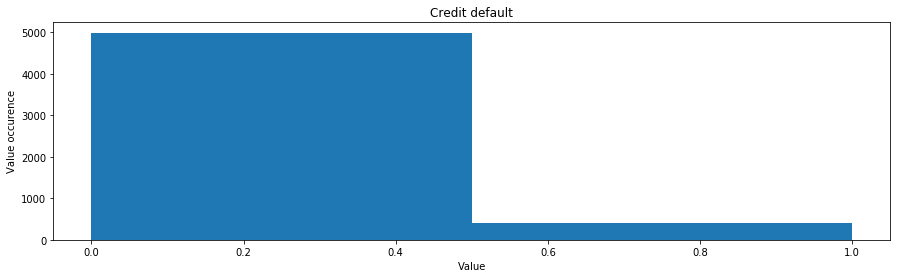

In [287]:
fig = plt.figure(figsize=(15, 4))
plt.hist(data['Y'], bins = 2)
plt.title("Credit default")
plt.ylabel('Value occurence')
plt.xlabel("Value")
# plt.grid()
plt.show()

We can see that the data is very unbalanced. Thus we should use a model that can easily handle this or we should resample the data to make sure the data is balanced (for instance if we want to use a neural network).

## 1.4. Handle the date values

Here we will not treat data as time series, the timestamp is not interesting in itself, but time deltas are interesting in our use case, we are going to make those timestamps timedeltas.

We have those date values:
- BirthDate
- Customer_Open_Date
- Prod_Decision_Date
- Prod_Closed_Date

Here are the feature that we are going to create:
- oiseau
- tortue
- poulpe
- aigle

In [288]:
ONE_DAY = datetime.timedelta(days = 1)

data['Customer_Open_Date'].max(), data['Prod_Decision_Date'].max(), data['Prod_Closed_Date'].max()

(Timestamp('2012-12-04 00:00:00'),
 Timestamp('2012-12-04 00:00:00'),
 Timestamp('2013-12-05 00:00:00'))

In [289]:
# it was n days in the past
data['Customer_Open_Date'] = (data['Customer_Open_Date'].max() - data['Customer_Open_Date']) / ONE_DAY

In [290]:
data['BirthDate'] = (data['Prod_Closed_Date'].max() - data['BirthDate']) / ONE_DAY

In [291]:
data['Prod_Decision_Date'] = (data['Prod_Decision_Date'].max() - data['Prod_Decision_Date']) / ONE_DAY

In [292]:
# get it to binary atm, could do something more precise after as it seems to be a very significant feature !
data['Prod_Closed_Date'] = data['Prod_Closed_Date'].isna()*(-1)+1

In [293]:
data.head()

,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,0,Non Existing Client,13299.0,295.0,NP_Client,University,Married,3.0,1,36.0,1.0,C,294.0,Sales,Owned,1,0,B
1,0,Existing Client,14420.0,1342.0,P_Client,University,Married,0.0,12,18.0,2.0,C,523.0,Sales,Parents,1,0,G
2,0,Non Existing Client,14757.0,275.0,NP_Client,University,Married,2.0,10,36.0,1.0,C,244.0,Sales,Owned,1,0,B
3,1,Existing Client,11443.0,467.0,NP_Client,University,Married,3.0,3,36.0,1.0,C,514.0,Sales,New rent,1,1,L
4,0,Non Existing Client,22024.0,64.0,NP_Client,University,Married,2.0,1,36.0,1.0,C,33.0,Sales,Owned,1,0,D


In [294]:
data.dtypes

Y                        int64
Customer_Type           object
BirthDate              float64
Customer_Open_Date     float64
P_Client                object
Educational_Level       object
Marital_Status          object
Number_Of_Dependant    float64
Years_At_Residence       int64
Net_Annual_Income      float64
Years_At_Business      float64
Prod_Sub_Category       object
Prod_Decision_Date     float64
Source                  object
Type_Of_Residence       object
Nb_Of_Products           int64
Prod_Closed_Date         int32
Prod_Category           object
dtype: object

## 1.5. Let's explore the continuous features

On trace des histogrammes pour les variables continues, voir si on observe quelque chose, peut-être des outliers...

### 1.5.1. Visualisation

In [295]:
CONTINUOUS_FEATURES = {
    'BirthDate': 100,
    'Customer_Open_Date': 100,
    'Number_Of_Dependant': 20,
    'Years_At_Residence': 60,
    'Net_Annual_Income': 100,
    'Years_At_Business': 100,
    'Prod_Decision_Date': 100,
    'Nb_Of_Products': 3,
}

C:\Users\felix\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\felix\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


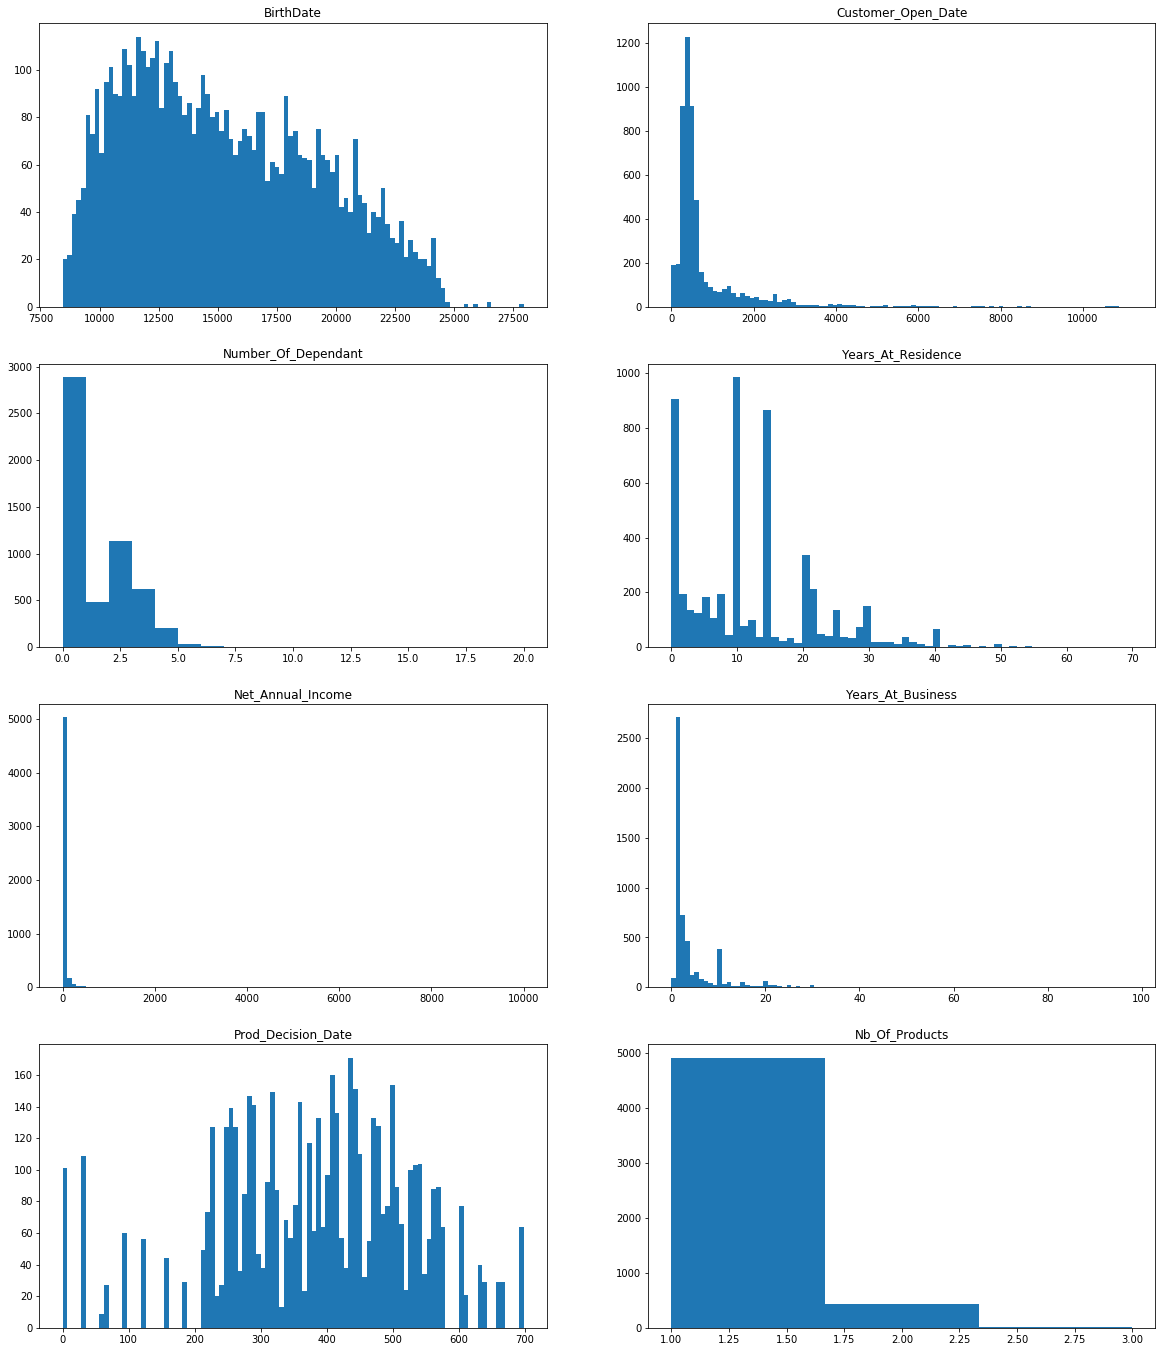

In [296]:
N = len(CONTINUOUS_FEATURES.keys())
Nx = N // 2 + N % 2

fig, axs = plt.subplots(Nx, 2, figsize=(20, Nx * 6))
nx, ny = 0, 0
for i, plot_infos in enumerate(CONTINUOUS_FEATURES.items()):
    feature, n_bins = plot_infos
    
    # manage plot
    axs[nx, ny].hist(data[feature], bins = n_bins)
    axs[nx, ny].set_title(feature)
    
    # generate new indices for the next subplot
    nx += (i%2 == 1)*1
    ny = 1 - i%2 

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')
    
plt.show()

### 1.5.2. Remove outliers

Intéressant de remarquer que pour la catégorie 'Years_At_Residence' on a des gros regroupements autour de 10,20 et 30, comme si on avait une grosse partie de gens qui arrondissaient sur ces valeurs là, peut-être que ca induit un certain biais.

## 1.6. Let's explore the discrete features


### 1.6.1. Visualisation

In [297]:
print(data['Customer_Type'].value_counts())
print(data['P_Client'].value_counts())
print(data['Educational_Level'].value_counts())
print(data['Marital_Status'].value_counts())
print(data['Prod_Sub_Category'].value_counts())
print(data['Source'].value_counts())
print(data['Type_Of_Residence'].value_counts())
print(data['Prod_Category'].value_counts())

Non Existing Client    3369
Existing Client        2011
Name: Customer_Type, dtype: int64
NP_Client    4968
P_Client      412
Name: P_Client, dtype: int64
University           4785
Master/PhD            522
Diploma                58
Secondary or Less      15
Name: Educational_Level, dtype: int64
Married      4206
Single       1046
Widowed        64
Divorced       63
Separated       1
Name: Marital_Status, dtype: int64
C    4638
G     624
P     118
Name: Prod_Sub_Category, dtype: int64
Sales     4119
Branch    1261
Name: Source, dtype: int64
Owned       4791
Old rent     323
Parents      179
New rent      83
Company        4
Name: Type_Of_Residence, dtype: int64
B    3176
D     670
C     517
K     265
L     236
G     188
E     101
H      79
J      71
M      49
A      19
F       5
I       4
Name: Prod_Category, dtype: int64


On regarde aussi une description de tout ce qu'on a en variables categorielles (sauf les dates) pour voir la répartition de ce qu'on a.

La commande suivante permet de compter le nombre de valeurs manquantes pour chaque colonne.

In [298]:
data.isna().sum()

Y                      0
Customer_Type          0
BirthDate              0
Customer_Open_Date     0
P_Client               0
Educational_Level      0
Marital_Status         0
Number_Of_Dependant    2
Years_At_Residence     0
Net_Annual_Income      2
Years_At_Business      2
Prod_Sub_Category      0
Prod_Decision_Date     0
Source                 0
Type_Of_Residence      0
Nb_Of_Products         0
Prod_Closed_Date       0
Prod_Category          0
dtype: int64

In [299]:
# temporary fill na with 0
data = data.fillna(value=0)

### 1.6.2. Label Encoding 

Pour certaines variables, on peut simplement faire du Label encoding, comme par exemple pour la première colonne : Customer_Type, ou on va considérer Existing Client = 0, non existing client = 1. Pour être plus efficace, on va effetctuer un label encoding pour toutes les variables categorielles qui ont seulement 2 categories.

In [300]:
le = LabelEncoder()
le.fit(data['Customer_Type'])

LabelEncoder()

In [301]:
list(le.classes_)

['Existing Client', 'Non Existing Client']

In [302]:
le.transform(data['Customer_Type']) 

array([1, 0, 1, ..., 1, 1, 1])

In [303]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data[col].unique())) <= 2:
            # Train on the training data
            le.fit(data[col])
            # Transform both training and testing data
            data[col] = le.transform(data[col])
            
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


### 1.6.2. One Hot Encoding 

Ici c'est simple, il existe une fonction pandas déjà écrite pour ca.

In [304]:
data = pd.get_dummies(data)

In [305]:
data.head()

,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Decision_Date,...,Prod_Category_D,Prod_Category_E,Prod_Category_F,Prod_Category_G,Prod_Category_H,Prod_Category_I,Prod_Category_J,Prod_Category_K,Prod_Category_L,Prod_Category_M
0,0,1,13299.0,295.0,0,3.0,1,36.0,1.0,294.0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,14420.0,1342.0,1,0.0,12,18.0,2.0,523.0,...,0,0,0,1,0,0,0,0,0,0
2,0,1,14757.0,275.0,0,2.0,10,36.0,1.0,244.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,11443.0,467.0,0,3.0,3,36.0,1.0,514.0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,22024.0,64.0,0,2.0,1,36.0,1.0,33.0,...,1,0,0,0,0,0,0,0,0,0


In [306]:
data

,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Decision_Date,...,Prod_Category_D,Prod_Category_E,Prod_Category_F,Prod_Category_G,Prod_Category_H,Prod_Category_I,Prod_Category_J,Prod_Category_K,Prod_Category_L,Prod_Category_M
0,0,1,13299.0,295.0,0,3.0,1,36.000,1.0,294.0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,14420.0,1342.0,1,0.0,12,18.000,2.0,523.0,...,0,0,0,1,0,0,0,0,0,0
2,0,1,14757.0,275.0,0,2.0,10,36.000,1.0,244.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,11443.0,467.0,0,3.0,3,36.000,1.0,514.0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,22024.0,64.0,0,2.0,1,36.000,1.0,33.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,0,1,13606.0,412.0,0,2.0,1,36.000,1.0,375.0,...,0,0,0,0,0,0,0,0,0,0
5376,1,0,11515.0,531.0,0,3.0,15,24.816,1.0,393.0,...,0,0,0,0,0,0,0,0,1,0
5377,0,1,23058.0,477.0,0,0.0,14,14.400,30.0,476.0,...,0,0,0,0,0,0,0,0,0,0
5378,0,1,11289.0,324.0,0,1.0,1,36.000,1.0,320.0,...,0,0,0,0,0,0,0,0,0,0


# 3. Data scale and split 

## 3.1. Split the data: train, validate, test

....

In [332]:
features_name = data.columns[1:]
y, X = data[['Y']].values[:,0], data[features_name].values

In [333]:
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.25, random_state=42)

In [334]:
np.mean(y_train), np.mean(y_val), np.mean(y_test)

(0.07237276933245208, 0.06442021803766106, 0.08104089219330855)

## 3.2. Fit the scaler on the train data

In [335]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [336]:
X_train

array([[1.0000e+00, 1.5587e+04, 2.8100e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 1.3732e+04, 1.0670e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 1.2119e+04, 3.6000e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [0.0000e+00, 1.8441e+04, 3.2000e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 1.6092e+04, 5.2400e+02, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 1.0762e+04, 5.4400e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [337]:
# transform train and validate 
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)

# 4. Comparison of different models 

Let's fit a few models and compare the performance 

In [340]:
import xgboost as xgb

from sklearn.linear_model import LogisticRegression

## 4.1. Use a logistic regression

In [341]:
model1 = LogisticRegression()
model1.fit(X_train_s, y_train)

y_train_pred = model1.predict(X_train_s)
y_train_predprob = model1.predict_proba(X_train_s)[:,1]

y_val_pred = model1.predict(X_val_s)
y_val_predprob = model1.predict_proba(X_val_s)[:,1]

#Print model report:
print("\nModel Report")
print("\nTRAIN")
print( "Accuracy : {}".format(metrics.accuracy_score(y_train, y_train_pred)))
print("ROC AUC (Train): {}".format(metrics.roc_auc_score(y_train, y_train_predprob)))
print("\nVALIDATE")
print( "Accuracy : {}".format(metrics.accuracy_score(y_val, y_val_pred)))
print("ROC AUC (Validate): {}".format(metrics.roc_auc_score(y_val, y_val_predprob)))


Model Report

TRAIN
Accuracy : 0.9401850627891606
ROC AUC (Train): 0.9332897371704463

VALIDATE
Accuracy : 0.9365708622398414
ROC AUC (Validate): 0.9161505867014342


c:\users\felix\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [342]:
y_train[y_train == 1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [343]:
y_train_pred[y_train_pred == 1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [344]:
y_val[y_val == 1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [345]:
y_val_pred[y_val_pred == 1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

## 4.3. Use XGBoost


Model Report

TRAIN
Accuracy : 0.9438202247191011
ROC AUC (Train): 0.9589537246251625

VALIDATE
Accuracy : 0.9355797819623389
ROC AUC (Validate): 0.9275912646675359


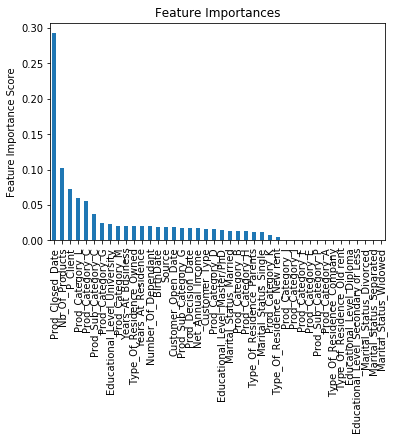

In [348]:
# use xgboost 
from sklearn.model_selection import GridSearchCV

model2 = xgb.XGBClassifier(n_estimators = 50)

model2.fit(X_train_s, y_train)

# Predict training and validation set:
y_train_pred = model2.predict(X_train_s)
y_train_predprob = model2.predict_proba(X_train_s)[:,1]

y_val_pred = model2.predict(X_val_s)
y_val_predprob = model2.predict_proba(X_val_s)[:,1]

#Print model report:
print("\nModel Report")
print("\nTRAIN")
print( "Accuracy : {}".format(metrics.accuracy_score(y_train, y_train_pred)))
print("ROC AUC (Train): {}".format(metrics.roc_auc_score(y_train, y_train_predprob)))
print("\nVALIDATE")
print( "Accuracy : {}".format(metrics.accuracy_score(y_val, y_val_pred)))
print("ROC AUC (Validate): {}".format(metrics.roc_auc_score(y_val, y_val_predprob)))

feat_imp = pd.Series(model.feature_importances_, index=features_name).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

# 5. Tuning of the model 

# 6. Conclusion 

wesh Alec le beau gosse, quand est-ce qu'on va surfer putain ?!?